In [1]:
#import dependencies
import keras
from keras.models import Sequential, save_model, load_model
from keras.utils import np_utils


import pydot
import graphviz
from keras.utils import plot_model



from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot



In [2]:
# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("training data = ", x_train.shape)
print("testing data = ", x_test.shape)

training data =  (50000, 32, 32, 3)
testing data =  (10000, 32, 32, 3)


In [3]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[-0.9619245 , -0.91515917, -0.8995707 ],
        [-1.2113398 , -1.1645745 , -1.1801629 ],
        [-1.1022207 , -1.1333976 , -1.2113398 ],
        ...,
        [ 0.58133286,  0.17603296, -0.19809005],
        [ 0.48780212,  0.06691375, -0.2916208 ],
        [ 0.4254483 ,  0.05132529, -0.27603233]],

       [[-1.6322283 , -1.5698744 , -1.5698744 ],
        [-1.8816435 , -1.8816435 , -1.8816435 ],
        [-1.6010513 , -1.756936  , -1.8816435 ],
        ...,
        [ 0.03573683, -0.5098592 , -1.0242784 ],
        [-0.026617  , -0.5878015 , -1.1022207 ],
        [ 0.02014837, -0.52544767, -0.9931014 ]],

       [[-1.4919322 , -1.5075206 , -1.554286  ],
        [-1.6322283 , -1.7725244 , -1.8816435 ],
        [-1.117809  , -1.4607552 , -1.756936  ],
        ...,
        [-0.04220546, -0.57221305, -1.1022207 ],
        [-0.01102854, -0.57221305, -1.1022207 ],
        [-0.18250158, -0.7436861 , -1.2269284 ]],

       ...,

       [[ 1.3607558 ,  0.7683944 , -0.38515157],
        [ 1

In [4]:
# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras 

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# let's display one of the one-hot encoded labels
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [5]:
# build the model

# number of hidden units variable 
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4 

# instantiate an empty sequential model 
model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer. 
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [6]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [7]:
# training
batch_size = 64
epochs=125

from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.125epochs.hdf5', verbose=1, save_best_only=True)

# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# optimizer = keras.optimizers.adam(lr=0.0005,decay=1e-6)

optimizer = keras.optimizers.RMSprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))


C:\Users\ulvi95\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
781/781 - 99s - loss: 2.1363 - accuracy: 0.3690 - val_loss: 1.4628 - val_accuracy: 0.5027

Epoch 00001: val_loss improved from inf to 1.46282, saving model to model.125epochs.hdf5
Epoch 2/125
781/781 - 46s - loss: 1.4744 - accuracy: 0.5183 - val_loss: 1.1703 - val_accuracy: 0.6137

Epoch 00002: val_loss improved from 1.46282 to 1.17034, saving model to model.125epochs.hdf5
Epoch 3/125
781/781 - 46s - loss: 1.2427 - accuracy: 0.5898 - val_loss: 1.1613 - val_accuracy: 0.6234

Epoch 00003: val_loss improved from 1.17034 to 1.16125, saving model to model.125epochs.hdf5
Epoch 4/125
781/781 - 47s - loss: 1.0994 - accuracy: 0.6355 - val_loss: 0.9018 - val_accuracy: 0.6970

Epoch 00004: val_loss improved from 1.16125 to 0.90176, saving model to model.125epochs.hdf5
Epoch 5/125
781/781 - 47s - loss: 1.0150 - accuracy: 0.6623 - val_loss: 0.9058 - val_accuracy: 0.7078

Epoch 00005: val_loss did not improve from 0.90176
Epoch 6/125
781/781 - 46s - loss: 0.9488 - accuracy: 0.6856 - val_


Epoch 00048: val_loss did not improve from 0.49140
Epoch 49/125
781/781 - 47s - loss: 0.5047 - accuracy: 0.8499 - val_loss: 0.5328 - val_accuracy: 0.8492

Epoch 00049: val_loss did not improve from 0.49140
Epoch 50/125
781/781 - 47s - loss: 0.4989 - accuracy: 0.8517 - val_loss: 0.5036 - val_accuracy: 0.8593

Epoch 00050: val_loss did not improve from 0.49140
Epoch 51/125
781/781 - 46s - loss: 0.4930 - accuracy: 0.8534 - val_loss: 0.5013 - val_accuracy: 0.8601

Epoch 00051: val_loss did not improve from 0.49140
Epoch 52/125
781/781 - 46s - loss: 0.4963 - accuracy: 0.8528 - val_loss: 0.4901 - val_accuracy: 0.8666

Epoch 00052: val_loss improved from 0.49140 to 0.49013, saving model to model.125epochs.hdf5
Epoch 53/125
781/781 - 47s - loss: 0.4976 - accuracy: 0.8534 - val_loss: 0.5190 - val_accuracy: 0.8547

Epoch 00053: val_loss did not improve from 0.49013
Epoch 54/125
781/781 - 47s - loss: 0.4955 - accuracy: 0.8546 - val_loss: 0.5205 - val_accuracy: 0.8545

Epoch 00054: val_loss did n


Epoch 00100: val_loss did not improve from 0.44335
Epoch 101/125
781/781 - 46s - loss: 0.4379 - accuracy: 0.8767 - val_loss: 0.4598 - val_accuracy: 0.8787

Epoch 00101: val_loss did not improve from 0.44335
Epoch 102/125
781/781 - 45s - loss: 0.4308 - accuracy: 0.8777 - val_loss: 0.4543 - val_accuracy: 0.8779

Epoch 00102: val_loss did not improve from 0.44335
Epoch 103/125
781/781 - 47s - loss: 0.4330 - accuracy: 0.8782 - val_loss: 0.4738 - val_accuracy: 0.8710

Epoch 00103: val_loss did not improve from 0.44335
Epoch 104/125
781/781 - 55s - loss: 0.4338 - accuracy: 0.8771 - val_loss: 0.4629 - val_accuracy: 0.8751

Epoch 00104: val_loss did not improve from 0.44335
Epoch 105/125
781/781 - 50s - loss: 0.4347 - accuracy: 0.8783 - val_loss: 0.5231 - val_accuracy: 0.8628

Epoch 00105: val_loss did not improve from 0.44335
Epoch 106/125
781/781 - 47s - loss: 0.4279 - accuracy: 0.8790 - val_loss: 0.4466 - val_accuracy: 0.8829

Epoch 00106: val_loss did not improve from 0.44335
Epoch 107/12

In [8]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 3s 26ms/step - loss: 0.4667 - accuracy: 0.8781

Test result: 87.810 loss: 0.467


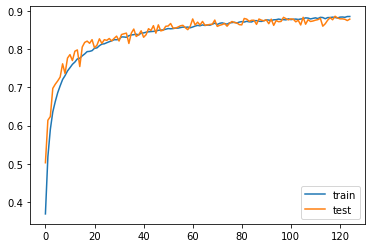

In [9]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

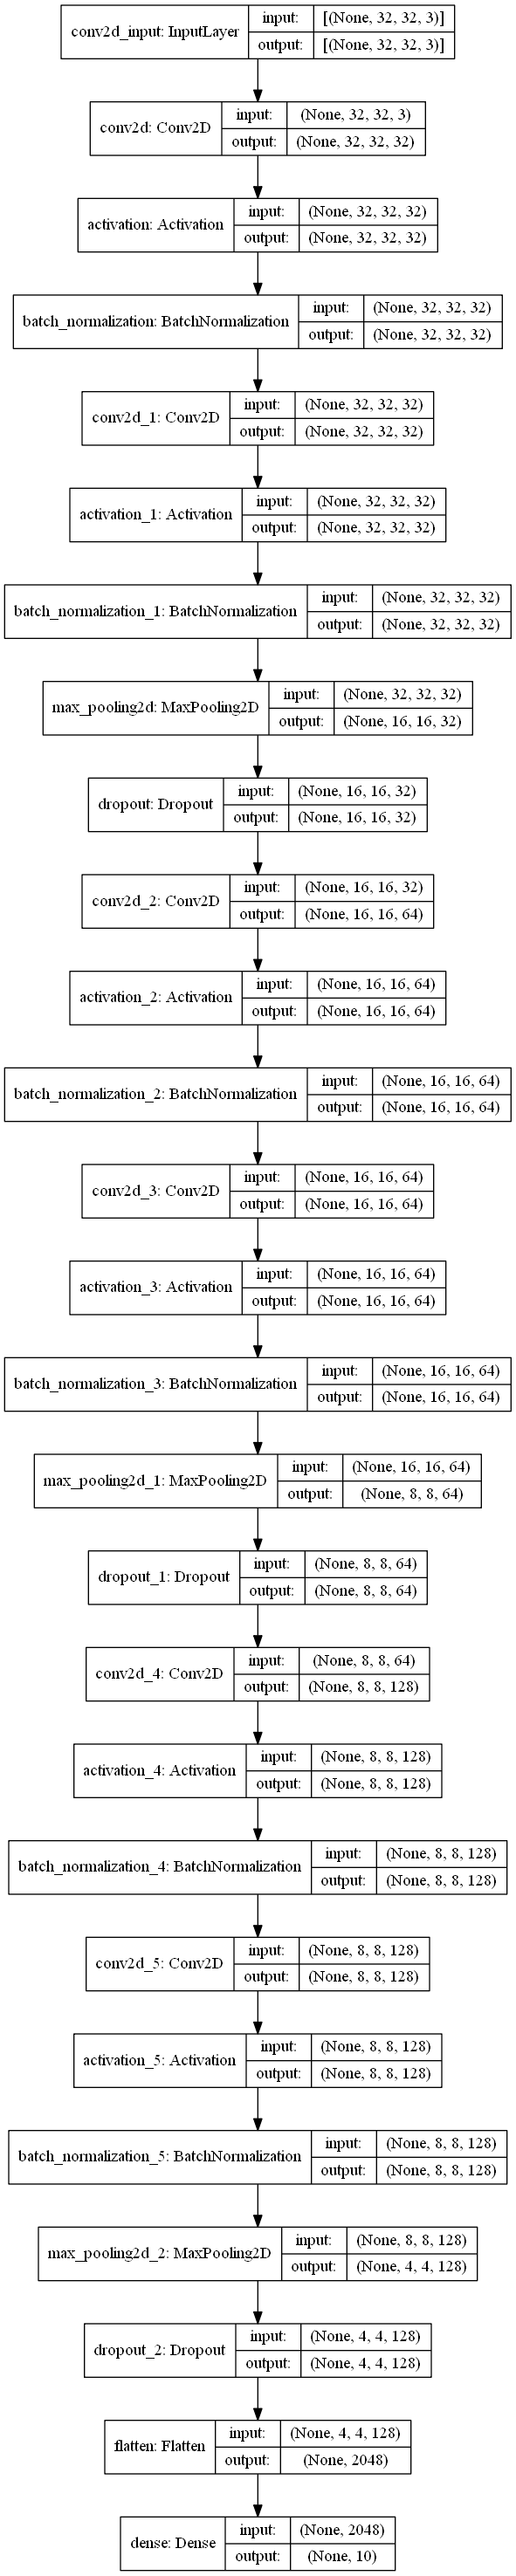

In [10]:
img_file = './model_arch.png'
plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)



In [11]:
filepath = './saved_model_for_project'
save_model(model, filepath)

INFO:tensorflow:Assets written to: ./saved_model_for_project\assets
